In [3]:
import os
import logging
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

from library.commons import check_parameters
from library.datahub import gen_etopo, get_station_data, open_topo

# config logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Setup

In [4]:
# set your domain, lon_min, lon_max, lat_min, lat_max
DOMAIN = [-80, -25, -60, 15]

# set your horizontal resolution in degrees
RES = 0.25

# set variables list
variables = ['tmax', 'tmin']

# set your start and end date
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 1, 1)

# set interpolation kwargs
interpol_kwargs = {
    "variogram_model": 'linear',
    "verbose": False,
    "enable_plotting": False,
    "exact_values": True,
    "coordinates_type": 'geographic',
    "pseudo_inv": True
}

# if true the lapse rate will be applied to make interpolate all station in the same altitude level
TEMPERATURE_VARS = True

# dry adiabatic lapse rate (9.8 °C/km)
LAPSE_RATE = -9.8 

# if true, save intermediate files, seeking to reduce the use of external APIs (meteostat and open topo data)
SAVE_STATIC_FILES = True

# set engine to handle with netcdf files
nc_engine = 'netcdf4'  # options 'netcdf4' and 'xarray'

# Checkings

Let's check the consistence of our settings before starting the process

In [5]:
NC_ENGINE = nc_engine.lower()  # avoid upper case errors
VARIABLES = [variables] if not isinstance(variables, list) else variables  # check right type

# this function will raise an error if the params are not consistents
check_parameters(NC_ENGINE, DOMAIN, RES, START_DATE, END_DATE, VARIABLES)

True

# Pre-processing

In [6]:
# set interpolated grid parameters
grid_lat = np.arange(DOMAIN[-2], DOMAIN[-1] + RES, RES)
grid_lon = np.arange(DOMAIN[0], DOMAIN[1] + RES, RES)

dates = pd.date_range(start=START_DATE, end=END_DATE, freq='1D').to_pydatetime()


# Getting stations file

For educational purposes, we'll use Meteostat to retrieve data from weather stations; any other CSV file can be used as long as it follows the same format.

It must be the following columns: station (which informs the id or name string), latitude, longitude and elevation, the column(s) with VARIABLES defined in setup is(are) necessary as well

In [7]:
# set specified domain to get weather station data, format (domain_top, domain_left), (domain_bottom, domain_right)
ws_outpath = f"static/stations_{DOMAIN[0]}_{DOMAIN[1]}_{DOMAIN[2]}_{DOMAIN[3]}_{START_DATE:%Y%m%d}_{END_DATE:%Y%m%d}.csv"

if os.path.exists(ws_outpath):
    logging.info(f"opening weather station file @ {ws_outpath}")
    daily_data = pd.read_csv(ws_outpath)
    
else:

    # get weather station data using meteostat
    daily_data = get_station_data(DOMAIN, START_DATE, END_DATE)
    
    if SAVE_STATIC_FILES:
        logging.info(f"creating csv with data station @ {ws_outpath}")
        daily_data.to_csv(ws_outpath)
    
# dropna and select columns
to_select_colunms = ['time', 'station', 'latitude', 'longitude', 'elevation'] + VARIABLES

try:
    daily_data = daily_data.dropna(subset=VARIABLES).reset_index()
    daily_data = daily_data.loc[:, to_select_colunms]

except KeyError as e:
    raise KeyError(f"there are variables not found in dataframe columns @ {e}")

daily_data['time'] = pd.to_datetime(daily_data['time'])

daily_data.head()

2024-10-03 07:24:39,987 - INFO - opening weather station file @ static/stations_-80_-25_-60_15_20240101_20240101.csv


,time,station,latitude,longitude,elevation,tmax,tmin
0,2024-01-01,69377,4.0700,-73.5500,378.0,31.2,21.0
1,2024-01-01,78792,9.0500,-79.3667,45.0,32.0,24.0
2,2024-01-01,78808,8.9833,-79.5500,66.0,33.0,25.0
3,2024-01-01,78922,14.7667,-60.8833,33.0,28.1,23.7
4,2024-01-01,78925,14.6000,-61.0000,5.0,30.0,22.0


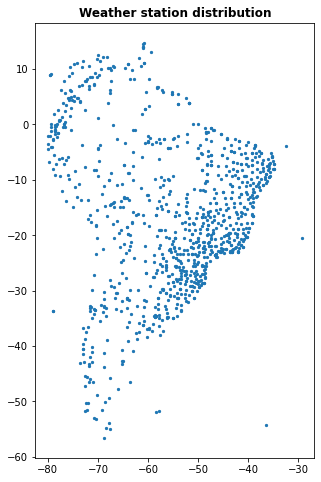

In [8]:
# a simple plot just to check the weather stations distribution
fig, ax = plt.subplots(figsize=(5, 8))
ax.scatter(daily_data['longitude'].values, daily_data['latitude'].values, s=5)
ax.set_title(f"Weather station distribution", weight='bold')
plt.show()
plt.close()

# Opening topography file

You can use another topography file, the final topo array must be in meters unit

In [9]:
topo_pathfile = f'static/ETOPO_lon_{DOMAIN[0]}_{DOMAIN[1]}_lat_{DOMAIN[2]}_{DOMAIN[3]}_r{RES}.nc'
should_open_topo = True

# you can use a specific topography file
# to ensure the right progress of the code, the netcdf file must be the following pattern
# dimensions: y (with latitude values in degrees) ; x (with longitude values in degrees)
# variable: z (y, x) - 2D array with elevation values in meters

# topo_pathfile = 'static/<your_netcdf_topography_file>.nc'  


# create etopo file from opentopodata api, it may take some time according to domain and horizontal resolution 
if not os.path.exists(topo_pathfile):
    if SAVE_STATIC_FILES:
        logging.info(f'Creating topo file for specific domain and resolution @ {DOMAIN} - {RES}')
        gen_etopo(grid_lat, grid_lon, topo_pathfile=topo_pathfile)
        
    else:
        topo = gen_etopo(grid_lat, grid_lon, topo_pathfile=topo_pathfile, save_output=False)
        should_open_topo = False
        


2024-10-03 07:24:42,361 - INFO - 
Checking boundaries:
    expected domain: [-80, -25, -60, 15]
    lats: (-60.0, 15.0)
    lons: (-80.0, -25.0)
        


CPU times: user 69.6 ms, sys: 10.8 ms, total: 80.4 ms
Wall time: 75.9 ms


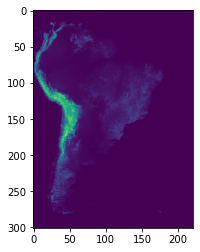

In [10]:
%%time
if should_open_topo:
    topo, lats_, lons_ = open_topo(topo_pathfile, grid_lat, grid_lon, nc_engine=NC_ENGINE)
    
    logging.info(
        f"""
Checking boundaries:
    expected domain: {DOMAIN}
    lats: {lats_[0], lats_[-1]}
    lons: {lons_[0], lons_[-1]}
        """
         )

topo[topo < 0] = 0  # avoid negative altitudes
plt.imshow(topo[::-1])

# Uniform elevations functions

Let's define functions to change temperature according with elevation using the lapse rate value defined in setup (temperature variables).

Some papers that stands out the importance of considering topography during a spatial interpolation of temperature:

**Böhner, J., & Antonic, O. (2009). Land-Surface Parameters Specific to Topo-Climatology. In T. Hengl & H. I. Reuter (Eds.), Developments in Soil Science (Vol. 33, pp. 195-226). Elsevier.**

**Lundquist, J. D., & Cayan, D. R. (2007). Surface Temperature Patterns in Complex Terrain: Daily Variations and Long-Term Change in the Central Sierra Nevada, California. Journal of Geophysical Research: Atmospheres, 112(D11).**



In [22]:
@np.vectorize
def alt2ground(arr, topo):
    '''
    going down with station data from elevation to sea level
    
    :param arr: np.array (1D)  - weather station temperature values
    :param topo: np.array (1D) - weather station elevation (in meters)
    '''
    return arr - LAPSE_RATE * (topo/1000)

@np.vectorize
def ground2alt(arr, topo):
    '''
    going up with interpolation result to surface elevation
    
    :param arr: np.array (2D)  - interpolated temperature values
    :param topo: np.array (2D) - topography grid array (in meters)
    '''
    return arr + LAPSE_RATE * (topo/1000)

# Applying interpol

## OrdinaryKriging

Ordinary Kriging is a spatial interpolation technique used to estimate unknown values at a point based on observed values at nearby points. This technique is widely used in geosciences, such as meteorology, geology, and mining, as it takes into account the distance and spatial correlation of the data.

Imagine you have temperature measurements from various locations and want to estimate the temperature at a location where no measurement was taken. Ordinary Kriging uses a mathematical model (described below) to estimate this value, considering the spatial "similarity" between the measured points. This similarity is called a variogram, which indicates how the variability of the data changes with distance.

### Kriging System of Equations

Once the variogram model is defined, the weights $( \lambda_i $) for the sampling points are calculated by solving a **system of linear equations** that takes into account the distances between points and the spatial correlation structure.

This system of equations can be represented as:

$$
\sum_{i=1}^{n} \lambda_i C(s_i, s_j) + \mu = C(s_0, s_j)
$$

Where:
- $( C(s_i, s_j) $) is the covariance between points $( s_i $) and $( s_j $).
- $( C(s_0, s_j) $) is the covariance between the point of interest $( s_0 $) and point $( s_j $).
- $( \mu $) is a Lagrange multiplier, ensuring that the sum of the weights $( \lambda_i $) equals 1, which ensures that Kriging is an unbiased estimator.

The Kriging system of equations is solved to find the weights $( \lambda_i $), which are then used to compute the estimate at point $( s_0 $) through the following equation:

$$
\hat{Z}(s_0) = \sum_{i=1}^{n} \lambda_i Z(s_i)
$$

Thus, Kriging takes into account both the spatial correlation and the variability structure of the observed data to provide optimal estimates at unknown locations.

In [23]:
interpolated_ds = {}
times = daily_data['time'].unique()
for variable in VARIABLES:
    interpolated_ds[variable] = []
    
    for date in times:
        
        logging.info(f"Starting {variable} interpolation @ {date:%Y%m%d}")
        
        df_date = daily_data.loc[daily_data['time'] == date]
        
        values_ws = df_date[variable].values
        lats_ws = df_date['latitude'].values
        lons_ws = df_date['longitude'].values
        elevation_ws = df_date['elevation'].values
        
        # uniform temperatures elevation before interpolate
        if TEMPERATURE_VARS:
            values_ws = alt2ground(values_ws, elevation_ws)
        
        # applying kriging
        OK = OrdinaryKriging(lons_ws,
                             lats_ws,
                             values_ws,
                             **interpol_kwargs)
        
        
        grid, ss = OK.execute('grid', grid_lon, grid_lat)
        
        # put the temperatures in the right elevation
        if TEMPERATURE_VARS:
            grid = ground2alt(grid, topo)

        interpolated_ds[variable].append(grid) 

        logging.info(f"Interpolation of {variable} on {date:%Y%m%d} done")

2024-10-03 08:02:47,231 - INFO - Starting tmax interpolation @ 20240101
2024-10-03 08:03:06,148 - INFO - Interpolation of tmax on 20240101 done
2024-10-03 08:03:06,149 - INFO - Starting tmin interpolation @ 20240101
2024-10-03 08:03:17,409 - INFO - Interpolation of tmin on 20240101 done


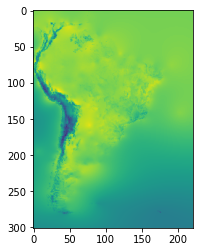

In [15]:
plt.imshow(interpolated_ds['tmax'][0][::-1])

# Universal Kriging

Universal Kriging is a more advanced variation of Ordinary Kriging. The main difference is that Universal Kriging considers a global trend in the data, such as gradual changes that may be related to external factors (like altitude, distance from the sea, etc.). While Ordinary Kriging assumes that the mean of the data is constant throughout the domain, Universal Kriging allows the mean to vary according to other variables.

For example, if you are interpolating temperature and know that it tends to decrease with altitude, you can incorporate altitude as a trend variable, which improves the estimates.

In [26]:
interpolated_ds = {}
times = daily_data['time'].unique()
for variable in VARIABLES:
    interpolated_ds[variable] = []
    
    for date in times:
        
        logging.info(f"Starting {variable} interpolation @ {date:%Y%m%d}")
        
        df_date = daily_data.loc[daily_data['time'] == date]
        
        values_ws = df_date[variable].values
        lats_ws = df_date['latitude'].values
        lons_ws = df_date['longitude'].values
        elevation_ws = df_date['elevation'].values
        
        interpol_kwargs2 = {kk: vv for kk, vv in interpol_kwargs.items() if kk not in ['coordinates_type']}
        UK = UniversalKriging(lons_ws,
                             lats_ws,
                             values_ws,
                             drift_terms='external_Z',
#                              specified_drift=elevation_ws,
                             external_drift=topo,
                             external_drift_y=grid_lat,
                             external_drift_x=grid_lon,
                             **interpol_kwargs2)

        grid, ss = UK.execute('grid', grid_lon, grid_lat, specified_drift_arrays=topo)


        interpolated_ds[variable].append(grid) 

        logging.info(f"Interpolation of {variable} on {date:%Y%m%d} done")

2024-10-03 08:22:41,910 - INFO - Starting tmax interpolation @ 20240101
2024-10-03 08:28:29,547 - INFO - Interpolation of tmax on 20240101 done
2024-10-03 08:28:29,548 - INFO - Starting tmin interpolation @ 20240101
2024-10-03 08:32:20,231 - INFO - Interpolation of tmin on 20240101 done


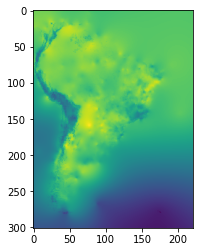

In [28]:
plt.imshow(interpolated_ds['tmax'][0][::-1])